In [135]:
import casadi as ca
import cyecca.lie as lie
from cyecca.util import rk4
from cyecca.symbolic import casadi_to_sympy
import numpy as np
import matplotlib.pyplot as plt
from ekf import derive_ekf_correct, derive_ekf_predict

In [136]:
def define_bearing_estimation_problem():
    u = ca.SX.sym("u", 3)
    x = ca.SX.sym("x", 3)
    p = ca.SX.sym("p", 0)

    x_h = ca.SX.sym("x_h", 3)
    x_e = ca.SX.sym("x_e", 3)
    t = ca.SX.sym("t")
    dt = ca.SX.sym("dt")
    cm = 1

    f_f = ca.Function(
        "f",
        [x, u, p, dt],
        [lie.SO3Dcm.exp(lie.so3.elem(-u * dt)).to_Matrix() @ x],
        ["x", "u", "p", "dt"],
        ["x1"],
    )

    f_h = ca.Function("h", [x, u, p], [x / ca.norm_2(x)], ["x", "u", "p"], ["h"])

    f_g = ca.Function("g", [x, u, p], [ca.dot(x, x)], ["x", "u", "p"], ["g"])

    f_ekf_predict = derive_ekf_predict(f_f)
    f_ekf_correct_h = derive_ekf_correct(f_h)
    f_ekf_correct_g = derive_ekf_correct(f_g)
    return locals()

Text(0.5, 1.0, 'EKF for bearing estimation')

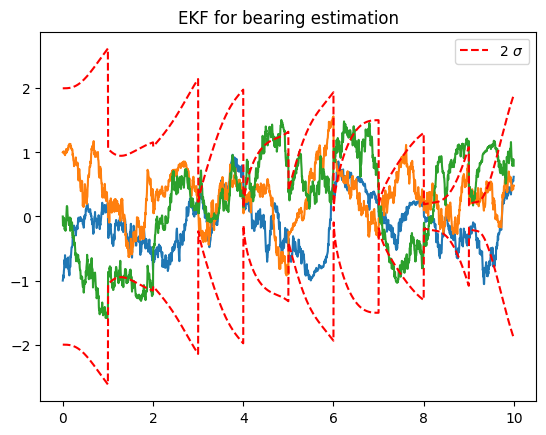

In [139]:
def simulate_bearing_estimation(problem):
    f_g = problem["f_g"]
    f_h = problem["f_h"]
    f_f = problem["f_f"]
    f_ekf_predict = problem["f_ekf_predict"]
    f_ekf_correct_h = problem["f_ekf_correct_h"]
    f_ekf_correct_g = problem["f_ekf_correct_g"]

    x = np.array([0, 1, 0])
    x_h = np.array([1, 0, 0])
    
    n_x = 3
    dt = 1.0/200
    tf = 10
    t_vect = np.arange(0, tf, dt)
    n_t = len(t_vect)
    
    data = {
        "x": np.zeros((n_t, n_x)),
        "x_h": np.zeros((n_t, n_x)),
        "t": t_vect,
        "P": np.zeros((n_t, n_x**2)),
    }

    p = np.array([])
    
    w_nasd = 0 # process noise amplitude spectral density
    w_std = w_nasd/np.sqrt(dt)
    
    gyro_nasd = 1 # gyro noise amplitude spectral density
    gyro_std = gyro_nasd/np.sqrt(dt)
    
    mag_std = 1e-3 # mag noise std dev.
    g_std = 1e-3 # g constraint std
    
    x0_std = 1

    P = np.eye(3)*x0_std**2
    Q = np.eye(3)*w_std**2
    M = np.eye(3)*gyro_std**2
    R_h = np.eye(3)*mag_std**2
    R_g = np.eye(1)*g_std**2

    x = x/ca.norm_2(x)
    x_h = x_h/ca.norm_2(x_h)

    for i, t in enumerate(t_vect):
        u = np.array([np.sin(t), np.cos(t), 1 - np.sin(t)])

        # store
        data["x"][i, :] = np.array(x).reshape(-1)
        data["x_h"][i, :]  = np.array(x_h).reshape(-1)
        data["P"][i, :] = np.array(P).reshape(-1)

        # simulate
        w_u = gyro_nasd/np.sqrt(dt)*np.random.randn(3)
        x = f_f(x, u + w_u, p, dt)
        x = x/ca.norm_2(x)
        
        x_h, P = f_ekf_predict(x_h, u, p, P, Q, M, dt)
        x_h = x_h/ca.norm_2(x_h)

        # correct mag
        if i != 0 and i %  int(1/dt) == 0:
            # magnetometer measurement
            y_h = f_h(x, u, p) + mag_std * np.random.randn(3)
            x_h, P = f_ekf_correct_h(x_h, u, p, y_h, P, R_h)
            x_h = x_h/ca.norm_2(x_h)

    return data


problem = define_bearing_estimation_problem()
data = simulate_bearing_estimation(problem)
plt.plot(data["t"], data["x"] - data["x_h"]);
h_bound = plt.plot(data["t"], 2*np.sqrt(data["P"][:, 0]), 'r--')[0];
plt.plot(data["t"], -2*np.sqrt(data["P"][:, 0]), 'r--');
plt.legend([h_bound], ['2 $\sigma$'])
plt.title('EKF for bearing estimation')